# Import

In [5]:
!pip install optuna

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import joblib # save and import model

# Constant

In [9]:
data_location = "/content/gdrive/MyDrive/First Year 2022-23/Spring 1 9-5 1 2023/NSC 325 Invester Program Energy/arXiv/data"

In [10]:
model_location = "/content/gdrive/MyDrive/First Year 2022-23/Spring 1 9-5 1 2023/NSC 325 Invester Program Energy/arXiv/model"

# data

In [11]:
df = pd.read_csv(f"{data_location}/UT_Comp_Seq_clean.csv", index_col=0)

In [13]:
# encode categorical varaibles
categorical_cols = df.select_dtypes(exclude=['number']).columns
df = pd.get_dummies(df, columns=categorical_cols)

In [15]:
df.to_csv(f"{data_location}/UT_Comp_Seq_encode.csv")

In [14]:
# standardize df
#from sklearn.preprocessing import StandardScaler
#cols = df.columns
#scaler = StandardScaler()
#df[cols] = scaler.fit_transform(df[cols])

In [15]:
# un-standardize df
#df[cols] = scaler.inverse_transform(df[cols])

# Split

In [16]:
x = df.drop('12 month Cum Prod', axis = 1) # Features
y = df['12 month Cum Prod']

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 121)

# Hyperparameter Tuning

In [95]:
# for 1 profile
def test_one_hyperparameter(hyperparameter, lower_bound, upper_bound, step=1, fix=None):
  rmse_xtest, rmse_xtrain = list(), list()

  for i in range(lower_bound, upper_bound, step):
    if fix is None:
      hyperpar_temp = {hyperparameter: i}
    else:
      hyperpar_temp = {hyperparameter: i}
      hyperpar_temp.update(fix)
    model = RandomForestRegressor(**hyperpar_temp)
    model.fit(x_train, y_train)
    # x test
    y_predict = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    rmse_xtest.append(rmse)
    # x train
    y_predict = model.predict(x_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_predict))
    rmse_xtrain.append(rmse)

  return rmse_xtest, rmse_xtrain

In [96]:
# for 1 profile
def plot_one_hyperparameter(rmse_xtest, rmse_xtrain, hyperparameter, lower_bound, upper_bound, step=1):
  x = range(lower_bound, upper_bound, step)

  plt.figure(figsize=(12,12))

  plt.plot(x, rmse_xtest, '-o', c="indianred", label="testing set")
  plt.plot(x, rmse_xtrain, '-o', c="steelblue", label="training set")


  fs = 18
  plt.xlabel(hyperparameter, fontsize=fs)
  plt.ylabel(f'Root Mean Square Error', fontsize=fs)
  title_temp = f"Random Forest Regressor"
  plt.title(title_temp, fontsize=fs)
  plt.legend(loc="best", fontsize=fs)
  plt.xticks(x)
  plt.tick_params(axis='both', which='both', width=1.5, labelsize=13, direction='in', top=True, right=True)
  plt.grid()

  plt.show()

## max_depth [10,25]

In [97]:
rmse_xtest, rmse_xtrain = test_one_hyperparameter("max_depth", 2, 25)

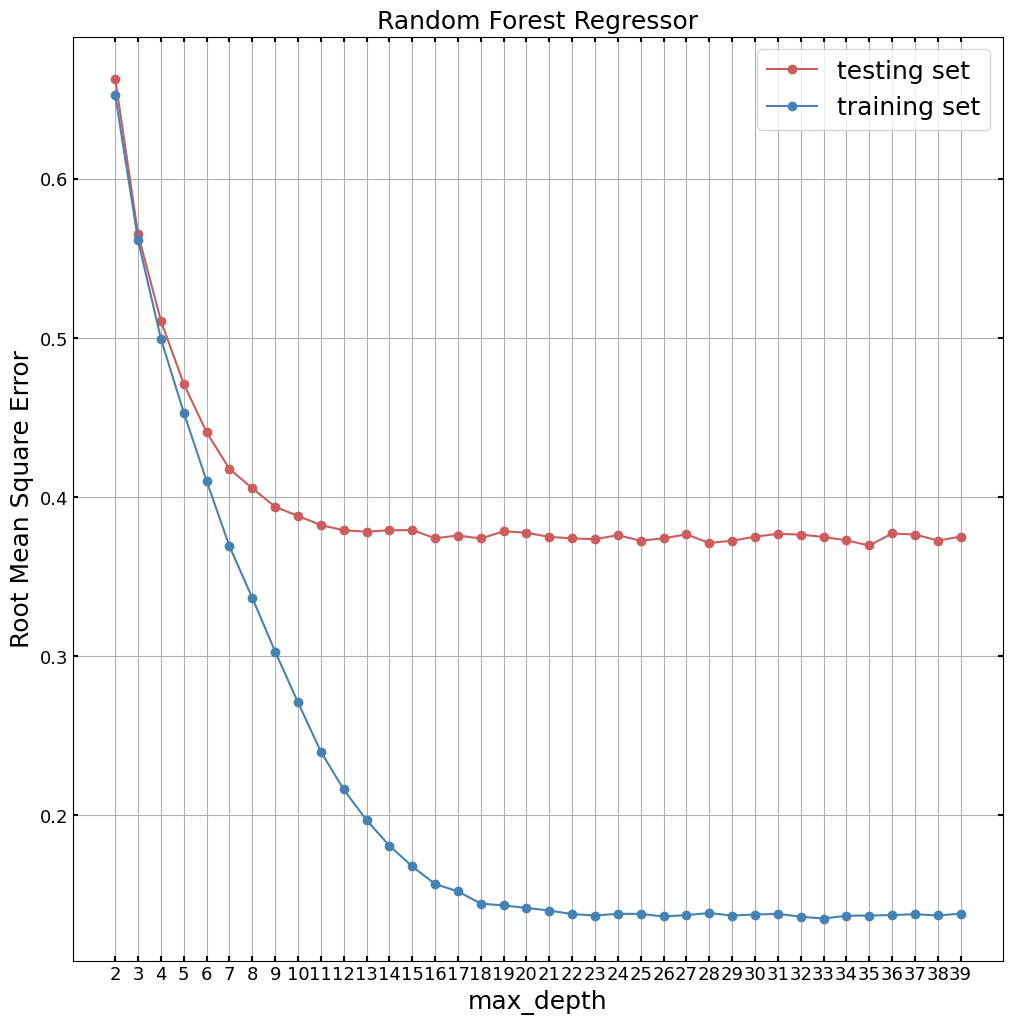

In [98]:
plot_one_hyperparameter(rmse_xtest, rmse_xtrain, "max_depth", 2, 25)

## min_samples leaf -> [2, 3]

In [99]:
rmse_xtest, rmse_xtrain = test_one_hyperparameter("min_samples_leaf", 2, 10)

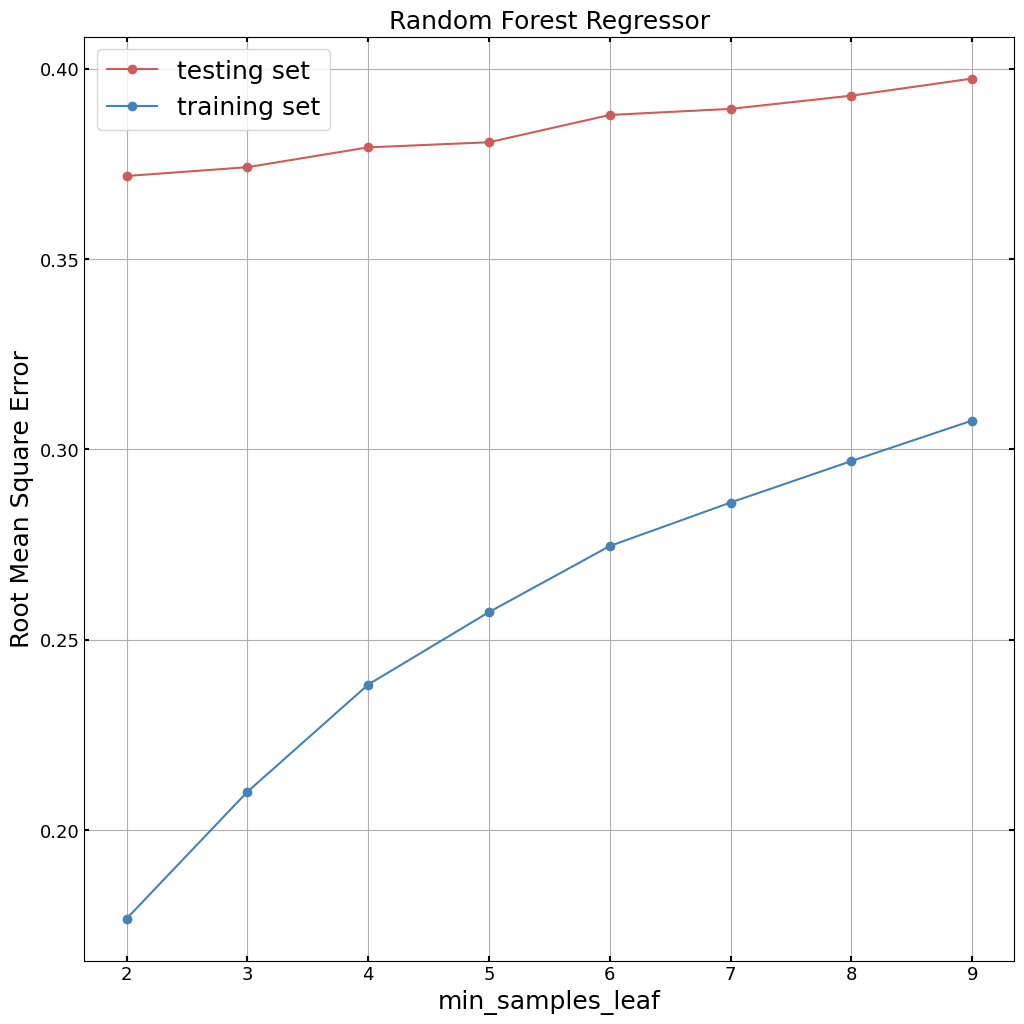

In [100]:
plot_one_hyperparameter(rmse_xtest, rmse_xtrain, "min_samples_leaf", 2, 10)

## min_samples_split -> [2,10]

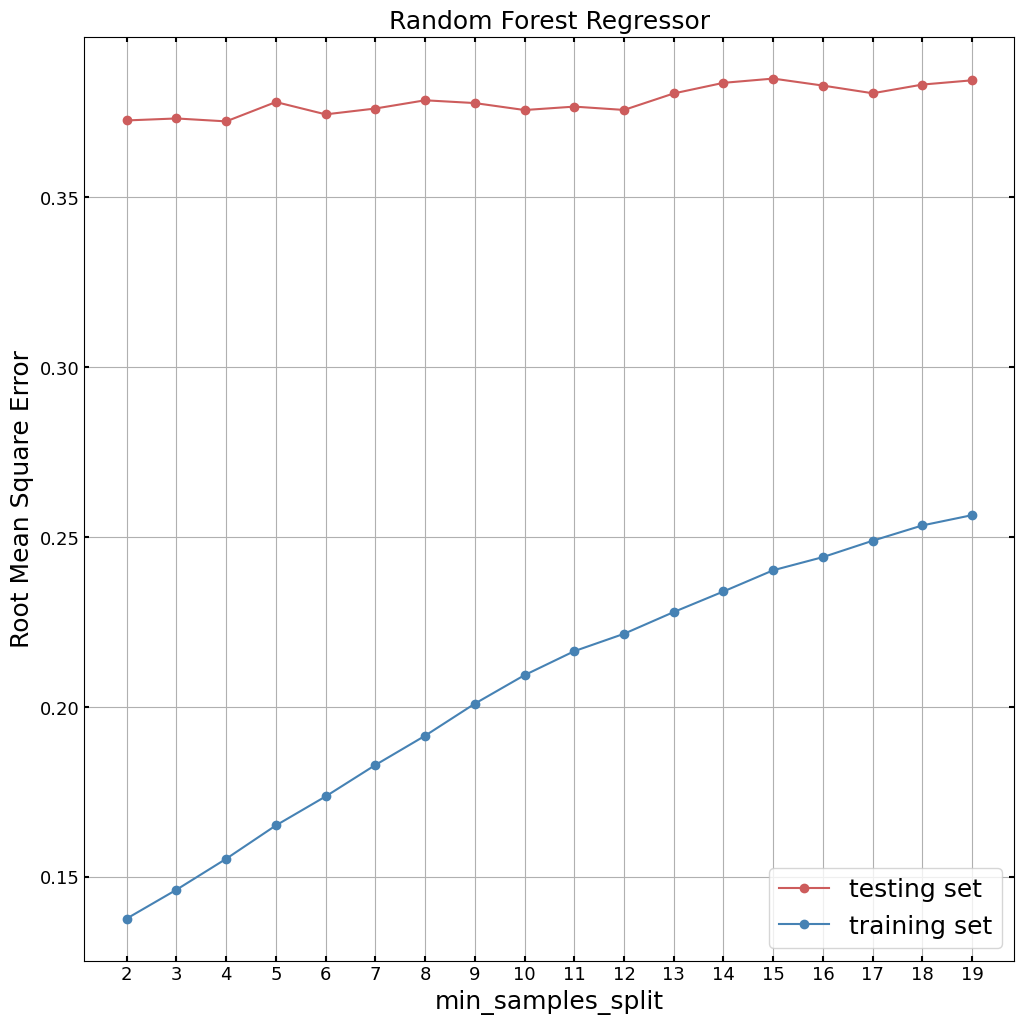

In [101]:
rmse_xtest, rmse_xtrain = test_one_hyperparameter("min_samples_split", 2, 20)
plot_one_hyperparameter(rmse_xtest, rmse_xtrain, "min_samples_split", 2, 20)

## n_sample -> 200

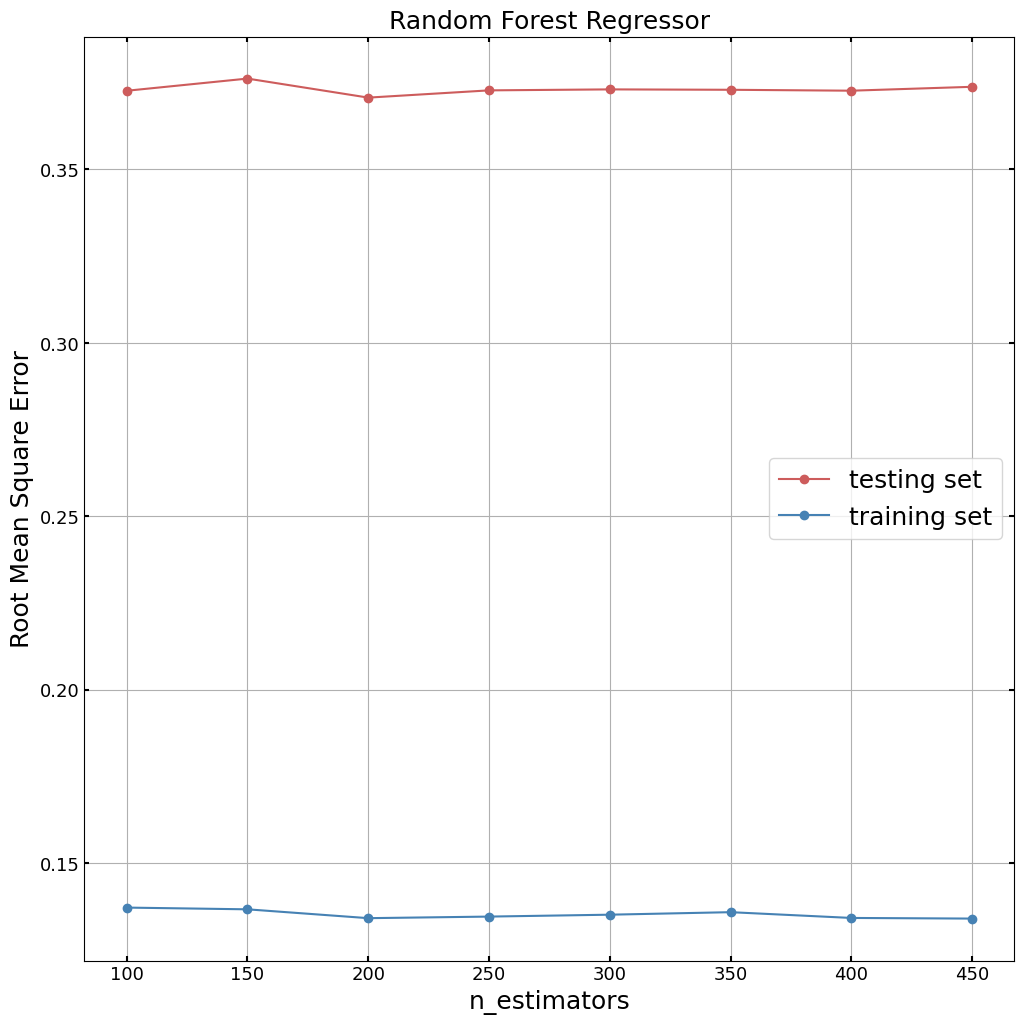

In [102]:
rmse_xtest, rmse_xtrain = test_one_hyperparameter("n_estimators", 100, 500, 50)
plot_one_hyperparameter(rmse_xtest, rmse_xtrain, "n_estimators", 100, 500, 50)

# Optuna

In [ ]:
def objective(trial):
    n_estimators = 200
    max_depth = trial.suggest_int('max_depth', 10, 25)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 3)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=121
    )

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    mse = mean_squared_error(y_test, y_pred)

    return mse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and their corresponding MSE
print('Best trial:')
print('  Value: ', study.best_trial.value)
print('  Params: ')
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

[I 2023-11-22 18:36:12,743] A new study created in memory with name: no-name-ef8a170b-c157-4584-b056-936f7164ca75
[I 2023-11-22 18:36:32,004] Trial 0 finished with value: 411.7917749431939 and parameters: {'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 411.7917749431939.
[I 2023-11-22 18:36:52,493] Trial 1 finished with value: 406.6074475931355 and parameters: {'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 1 with value: 406.6074475931355.
[I 2023-11-22 18:37:17,042] Trial 2 finished with value: 401.91023640714633 and parameters: {'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 2 with value: 401.91023640714633.
[I 2023-11-22 18:37:38,285] Trial 3 finished with value: 408.2397826208951 and parameters: {'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 2 with value: 401.91023640714633.
[I 2023-11-22 18:37:56,987] Trial 4 finished with value: 407.046422

# RF 1 best

In [18]:
hyperpar = {'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 2, 'n_estimators': 200,
            'random_state': 121}

In [19]:
model = RandomForestRegressor(**hyperpar)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [20]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 400.52514982127974


In [21]:
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

R-squared: 0.8603596977122323


In [22]:
# Save the model to a file
joblib.dump(model, f"{model_location}/random_forest_model.joblib")

['/content/gdrive/MyDrive/First Year 2022-23/Spring 1 9-5 1 2023/NSC 325 Invester Program Energy/arXiv/model/random_forest_model.joblib']

# RF 2

In [41]:
hyperpar = {'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 2, 'n_estimators': 1000,
            'random_state': 121}

In [42]:
model = RandomForestRegressor(**hyperpar)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Squared Error: 402.16933888178625
R-squared: 0.8597864626543843
